In [1]:
#in this notebook, I also attempt to find how each STU filter can be represented as a linear combination of LDSs
#however, to do this we will fit many STUs to LDSs and then use the learned weights to represent the STU as a linear combination of LDSs

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional  as  F
import math
import numpy as np

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

In [3]:
from convolve import convolve, nearest_power_of_two
from stu import STU
from lds_utils import compute_ar_x_preds
from lds import LDS

Unable to import FlashFFTConv: No module named 'flashfftconv'. Falling back to PyTorch implementation.


In [4]:
def random_LDS(d_h: int, d_o: int, d_u: int, lower_bound: float):
  """
  makes a random LDS with hidden state dimension d_h, observation dimension d_o, and control dimension d_u.
  `lower_bound` is a float in [0, 1] specifying the minimum absolute value for entries in A.
  Each entry in A will be in [lower_bound, 1] multiplied by +/-1 with equal probability.
  """
  # Create LDS instance
  lds = LDS(state_dim=d_h, input_dim=d_u, output_dim=d_o, kx=0, dtype=torch.float32)
  
  # Override the A parameter with custom initialization
  A_values = torch.rand(d_h) * (1 - lower_bound) + lower_bound
  signs = torch.randint(0, 2, (d_h,)) * 2 - 1
  lds.A = nn.Parameter((A_values * signs.float()).to(device))
  
  # Initialize other parameters randomly
  lds.B = nn.Parameter(torch.randn(d_u, d_h).to(device) / d_u)
  lds.C = nn.Parameter(torch.randn(d_h, d_o).to(device) / d_h)
  lds.h0 = nn.Parameter(torch.zeros(d_h).to(device))
  
  return lds

In [36]:
d_h = 1
d_in = 1
d_out =1
lds  =  random_LDS(d_h = d_h, d_o =  d_out, d_u = d_in, lower_bound= 0.9)
print(lds.A)

Parameter containing:
tensor([-0.9517], requires_grad=True)


In [37]:
use_hankel_L  = False
phi = torch.tensor(np.load('spectral_filters.npy')).to(device).to(torch.float32)
seq_len, num_eigh = 8192, 24
# phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L, device  = device,  dtype = torch.float32)
n = nearest_power_of_two(seq_len * 2 - 1, round_up=True)

class Config:
    def __init__(self):
        self.num_eigh = num_eigh
        self.use_hankel_L = use_hankel_L
        self.torch_dtype = torch.float32
        self.n_embd = 1  # d_in and d_out
        self.seq_len = seq_len
        self.k_u = 0
        self.use_flash_fft = torch.cuda.is_available() #if cuda is available, flash_fft is available
        self.use_approx = False

stu_config = Config()

In [ ]:
def train_stu(lds, verbose = True):
    model = STU(stu_config, phi, n).to(device)
    lr = 1
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

    steps = 5_000 # @param
    model.train()

    bsz = 1

    for step in range(steps):
        inputs = torch.randn(bsz * seq_len, d_in).to(device)
        
        # Use torch.no_grad() to avoid storing gradient information for LDS
        with torch.no_grad():
            targets = lds.generate_trajectory(inputs)

        inputs = inputs.reshape(bsz, seq_len, d_in).to(device)
        targets = targets.reshape(bsz, seq_len, d_out).to(device)
        loss = model.loss(inputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0 and verbose:
            print(f"Step {step}: Loss = {loss.item()}")

    model.eval()
    return model, loss
stu_model, _ = train_stu(lds)

Step 0: Loss = 19.812702178955078


In [9]:
import matplotlib.pyplot as plt

# Generate random input and get trajectories
test_input = torch.randn(seq_len, d_in).to(device)
test_input = test_input.unsqueeze(0) # Add batch dimension

# Get STU trajectory
with torch.no_grad():
    stu_trajectory = stu_model(test_input).squeeze()

# Get LDS trajectory 
lds_trajectory = lds.reset().generate_trajectory(test_input.squeeze(0)).to(device)

gap = stu_trajectory - lds_trajectory[:, 0]
# Plot both trajectories
plt.figure(figsize=(10, 6))
plt.plot(stu_trajectory.cpu().numpy(), label='STU Model')
plt.plot(lds_trajectory.cpu().numpy(), label='LDS Model', linestyle='--')
plt.plot(gap.cpu().numpy(), label='Gap')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Comparison of STU and LDS Trajectories')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'stu_model' is not defined

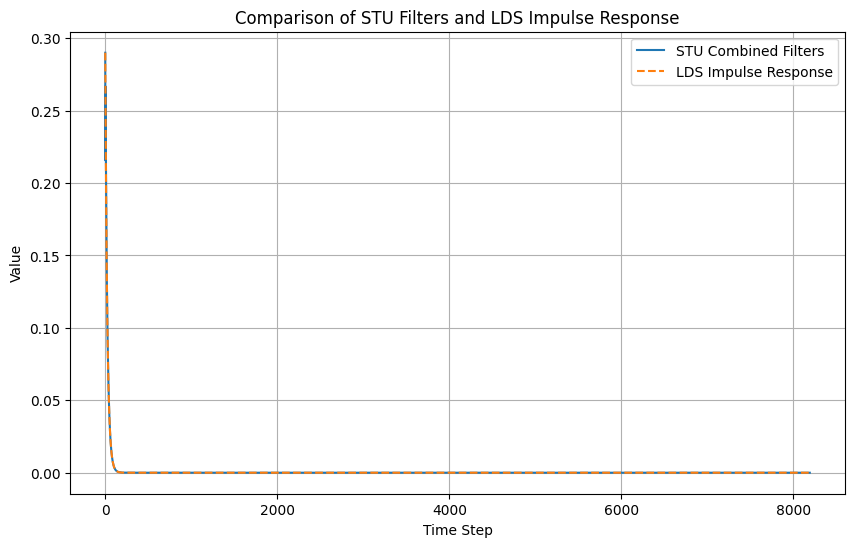

In [61]:
# Get the STU filters and weights
filters = phi.T  # Shape: [num_filters, seq_len]
pos_weights = stu_model.M_phi_plus[:,0,0] # Shape: [1, num_filters]
neg_weights = stu_model.M_phi_minus[:,0,0] # Shape: [1, num_filters]
# Multiply each filter by its weight and sum
pos_weighted_filters = (filters.T @ pos_weights.T).squeeze()  # Shape: [seq_len]
neg_weighted_filters = (filters.T @ neg_weights.T).squeeze()  # Shape: [seq_len]

weighted_filters = pos_weighted_filters + neg_weighted_filters

# For LDS, compute the impulse response
lds_impulse = torch.zeros(seq_len)
for i in range(seq_len):
    a_power = lds.A ** i
    lds_impulse[i] = torch.sum(lds.C[:,0] * a_power * lds.B[0])

# Plot both
plt.figure(figsize=(10, 6))
plt.plot(weighted_filters.detach().cpu().numpy(), label='STU Combined Filters')
plt.plot(lds_impulse.cpu().numpy(), label='LDS Impulse Response', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Comparison of STU Filters and LDS Impulse Response')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
import numpy as np
import tqdm

ldss = []
pos_weights_matrix = []
neg_weights_matrix = []
autoreg_weights_matrix = []
losses = []
store = []

In [170]:
for i in tqdm.tqdm(range(200)):
 
    new_lds = random_LDS(d_h = d_h, d_o = d_out, d_u = d_in, lower_bound= 0.95)  # Replace LDS with the actual class constructor if different
    
    # Fit STU to the LDS
    stu, loss = train_stu(new_lds, verbose = False)
    
    # Extract positive and negative weights
    pos_weights = stu.M_phi_plus[:, 0, 0].detach().cpu().numpy()  # Shape: [num_filters]
    neg_weights = stu.M_phi_minus[:, 0, 0].detach().cpu().numpy()  # Shape: [num_filters]
    auto_reg = stu.M.detach().cpu().numpy()
    autoreg_weights_matrix.append(auto_reg)
    
    pos_weights_matrix.append(pos_weights)
    neg_weights_matrix.append(neg_weights)
    losses.append(loss)
    store.append([new_lds, stu])

    ldss.append(new_lds)


100%|██████████| 200/200 [14:44<00:00,  4.42s/it]


In [292]:
# Save store to file using pickle
import pickle

# Create a filename with timestamp
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'stu_lds_store_{timestamp}.pkl'

# Extract just the necessary data from store to avoid pickling issues
store_data = []
for lds, stu in store:
    # Extract LDS parameters
    lds_params = {
        'A': lds.A.detach().cpu().numpy(),
        'B': lds.B.detach().cpu().numpy(),
        'C': lds.C.detach().cpu().numpy(),
        'D': lds.D.detach().cpu().numpy(),
        'h0': lds.h0.detach().cpu().numpy(),
    }
    
    # Extract STU parameters
    stu_params = {
        'M_phi_plus': stu.M_phi_plus.detach().cpu().numpy(),
        'M_phi_minus': stu.M_phi_minus.detach().cpu().numpy(),
        'M': stu.M.detach().cpu().numpy()
    }
    
    store_data.append((lds_params, stu_params))

# Save the extracted data to file
with open(filename, 'wb') as f:
    pickle.dump(store_data, f)

print(f"Saved store data to {filename}")


Saved store data to stu_lds_store_20250221_213044.pkl


In [171]:

def gen_lds_impulse(lds,autoreg): #need the stu for to add the negative autoregressive component
    lds_impulse = torch.zeros(seq_len)
    for i in range(stu_config["k_u"]):
        lds_impulse[i] = -1 * torch.tensor(autoreg[0][0][i])
    for i in range(seq_len):
        a_power = lds.A ** i
        lds_impulse[i] += torch.sum(lds.C[:, 0] * a_power * lds.B[0]).cpu()
    return lds_impulse

phi_n = phi.data.cpu().numpy()

def gen_stu_impulse(stu):
    alt_sign = lambda x: x * np.array([1, -1] * 512)
    pos_coef = stu.M_phi_plus.data.cpu().numpy()[:, 0,0]
    neg_coef = stu.M_phi_minus.data.cpu().numpy()[:,0,0]
    impulse = np.sum(phi_n*pos_coef, axis = -1) + alt_sign(np.sum(phi_n*neg_coef, axis = -1))
    return impulse

In [246]:
# Get impulse responses for both LDS and STU models and store with MSE losses
pairs_with_mse = []

for lds, stu in store:
    lds_impulse = gen_lds_impulse(lds, stu.M.detach().cpu().numpy())
    stu_impulse = gen_stu_impulse(stu)
    
    # Calculate MSE between impulse responses
    mse = F.mse_loss(torch.tensor(lds_impulse)[10:], torch.tensor(stu_impulse)[10:])
    
    # Store pair with its MSE
    pairs_with_mse.append((mse, lds, stu))

# Sort by MSE and take top 40
pairs_with_mse.sort(key=lambda x: x[0])
filtered_store = [(lds, stu) for _, lds, stu in pairs_with_mse[:40]]

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_23354/1884438642.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = F.mse_loss(torch.tensor(lds_impulse)[10:], torch.tensor(stu_impulse)[10:])


In [247]:
# Create alternating sign pattern of length 1024
alternating_signs = np.array([1, -1] * 512)

# Multiply phi_n by alternating signs to get alternated version
phi_n_alternating = phi_n * alternating_signs[:, np.newaxis]
# Concatenate original and alternating versions along second axis
phi_n_combined = np.concatenate([phi_n, phi_n_alternating], axis=1)  # Shape: (1024, 40)


In [248]:
# For each STU, combine M_phi_plus and M_phi_minus
combined_weights = []
for _, stu in filtered_store:
    # Get M_phi_plus and M_phi_minus from STU model
    M_phi_plus = stu.M_phi_plus.detach().cpu().numpy()[:,0,0]
    M_phi_minus = stu.M_phi_minus.detach().cpu().numpy()[:,0,0]
    
    # Concatenate the weights
    combined = np.concatenate([M_phi_plus, M_phi_minus], axis=0)
    combined_weights.append(combined)

# Stack all combined weights into a single array
combined_weights = np.stack(combined_weights)
combined_weights.shape


(40, 40)

Maximum MSE between any reconstructed and original impulse pair: 1.30e-16 (at index 0)


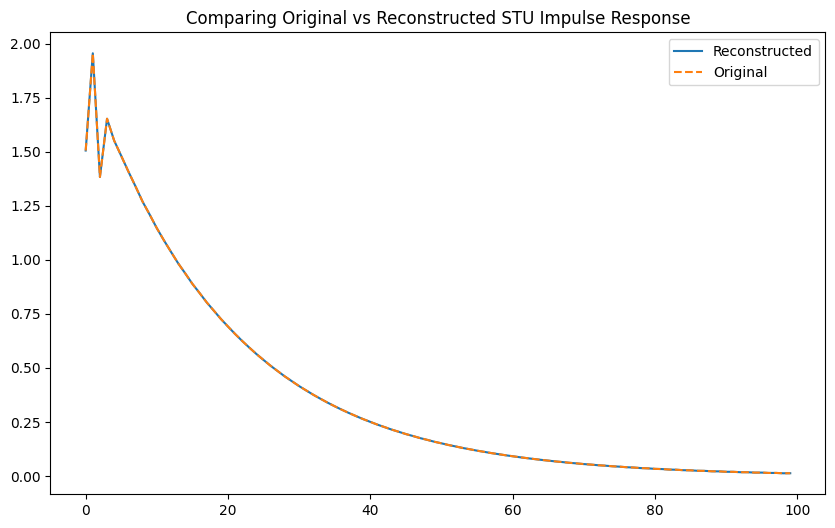

In [274]:
# Reconstruct STU filters using combined weights and phi_n_combined
reconstructed_filters = np.matmul(phi_n_combined, combined_weights.T)  # Shape: (1024, num_models)

# Get original STU impulse responses for comparison
original_impulses = []
for _, stu in filtered_store:
    impulse = gen_stu_impulse(stu)
    original_impulses.append(impulse)
original_impulses = np.stack(original_impulses).T  # Shape: (1024, num_models)

# Compare reconstructed vs original
# Calculate MSE between each pair of reconstructed and original impulses
mses = []
for i in range(reconstructed_filters.shape[1]):
    mse = F.mse_loss(torch.tensor(reconstructed_filters[:,i]), torch.tensor(original_impulses[:,i]))
    mses.append(mse.item())

max_mse = max(mses)
max_idx = mses.index(max_mse)
print(f"Maximum MSE between any reconstructed and original impulse pair: {max_mse:.2e} (at index {max_idx})")

plt.figure(figsize=(10, 6))
plt.plot(reconstructed_filters[:100,0], label='Reconstructed')
plt.plot(original_impulses[:100,0], '--', label='Original') 
plt.title('Comparing Original vs Reconstructed STU Impulse Response')
plt.legend()
plt.show()

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_23354/1789712089.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi_n_approx = np.matmul(torch.tensor(original_impulses), combined_weights_pinv)


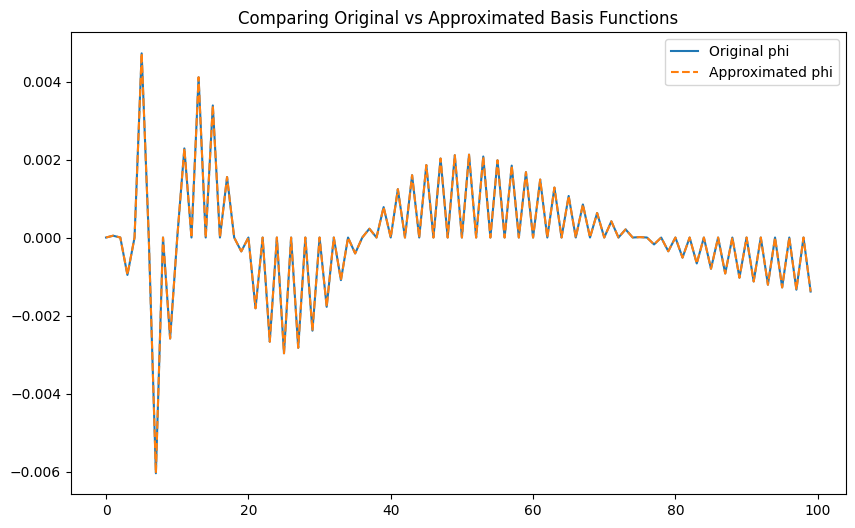

MSE between original and approximated phi: 5.60e-12


/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_23354/1789712089.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = F.mse_loss(torch.tensor(phi_n_combined), torch.tensor(phi_n_approx))


In [257]:
# Use pseudoinverse to solve for phi_n_combined
# reconstructed_filters = phi_n_combined @ combined_weights.T
# Therefore: phi_n_combined = reconstructed_filters @ pinv(combined_weights.T)
combined_weights_pinv = np.linalg.pinv(combined_weights.T)
phi_n_approx = np.matmul(torch.tensor(original_impulses), combined_weights_pinv)

# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:100,0], label='Original phi')
plt.plot(phi_n_approx[:100,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(torch.tensor(phi_n_combined), torch.tensor(phi_n_approx))
print(f"MSE between original and approximated phi: {mse:.2e}")


In [268]:
# Generate impulse responses for LDS models
lds_impulses = []
for lds, stu in filtered_store:
    impulse = gen_lds_impulse(lds, stu.M.detach().cpu().numpy())
    lds_impulses.append(impulse)
lds_impulses = np.stack(lds_impulses).T  # Shape: (1024, num_models)


In [ ]:
# simulating adding 10 autoregressive terms
lds_impulses[:10, :] = original_impulses[:10, :]


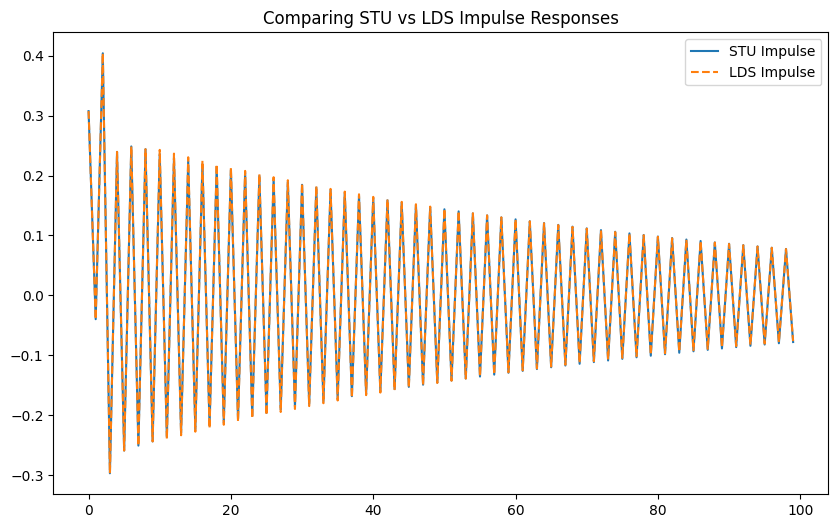

MSE between STU and LDS impulse 0: 2.41e-07
MSE between STU and LDS impulse 1: 3.30e-07
MSE between STU and LDS impulse 2: 3.34e-07
MSE between STU and LDS impulse 3: 3.59e-07
MSE between STU and LDS impulse 4: 4.02e-07
MSE between STU and LDS impulse 5: 4.02e-07
MSE between STU and LDS impulse 6: 4.16e-07
MSE between STU and LDS impulse 7: 4.27e-07
MSE between STU and LDS impulse 8: 4.27e-07
MSE between STU and LDS impulse 9: 4.29e-07
MSE between STU and LDS impulse 10: 4.52e-07
MSE between STU and LDS impulse 11: 5.03e-07
MSE between STU and LDS impulse 12: 5.04e-07
MSE between STU and LDS impulse 13: 5.09e-07
MSE between STU and LDS impulse 14: 5.40e-07
MSE between STU and LDS impulse 15: 5.41e-07
MSE between STU and LDS impulse 16: 5.49e-07
MSE between STU and LDS impulse 17: 5.59e-07
MSE between STU and LDS impulse 18: 5.91e-07
MSE between STU and LDS impulse 19: 6.01e-07
MSE between STU and LDS impulse 20: 6.07e-07
MSE between STU and LDS impulse 21: 6.08e-07
MSE between STU and 

In [279]:
# Compare original STU impulses with LDS impulses
plt.figure(figsize=(10, 6))
plt.plot(original_impulses[:100,31], label='STU Impulse')
plt.plot(lds_impulses[:100,31], '--', label='LDS Impulse')
plt.title('Comparing STU vs LDS Impulse Responses')
plt.legend()
plt.show()

# Calculate MSE between STU and LDS impulses
for i in range(40):
    mse = F.mse_loss(torch.tensor(lds_impulses[:, i]), torch.tensor(original_impulses[:, i]))
    print(f"MSE between STU and LDS impulse {i}: {mse:.2e}")


In [281]:
combined_weights_pinv

array([[  4.2072105 , -19.6708    ,  -0.7451036 , ...,  -0.5234049 ,
          1.581902  ,   0.9195743 ],
       [ 15.278405  ,   5.4845276 , -34.892834  , ...,   1.0296582 ,
         -0.336941  ,  -0.20368268],
       [  4.57775   ,  -2.4853885 ,  -4.4265885 , ...,  -1.2707949 ,
         -0.7450217 ,   0.55619156],
       ...,
       [  2.982441  ,  -2.950063  ,  -1.8422621 , ...,   0.7165477 ,
          0.7807894 ,   0.28733796],
       [  5.7486176 , -14.154145  ,  -7.8163424 , ...,  -1.0426036 ,
          0.7122676 ,   0.9027705 ],
       [ 11.270642  ,  -4.8922586 , -18.654688  , ...,  -2.0359683 ,
          2.0235436 ,  -0.5992537 ]], shape=(40, 40), dtype=float32)

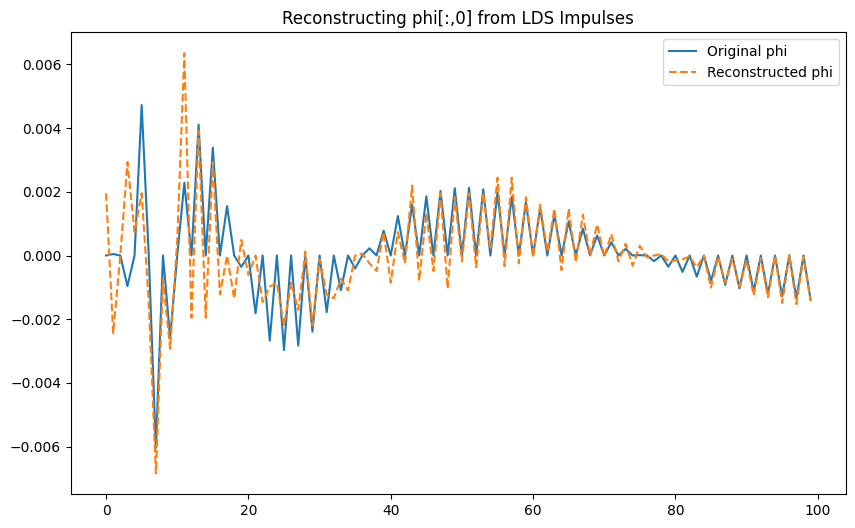

MSE between original and reconstructed phi: 8.93e-08

Largest magnitude coefficients:
LDS 6: -50240.0820
LDS 19: 48634.0898
LDS 4: 48364.0273
LDS 3: -42926.2539
LDS 38: -37307.7969


In [284]:
# Find optimal coefficients to reconstruct phi[:,0] using least squares
target_phi = phi[:,0].cpu().numpy()
coefficients, residuals, rank, s = np.linalg.lstsq(lds_impulses, target_phi, rcond=None)

# Reconstruct phi using optimal coefficients
reconstructed_phi = np.dot(lds_impulses, coefficients)

# Plot original vs reconstructed phi
plt.figure(figsize=(10, 6))
plt.plot(target_phi[:100], label='Original phi')
plt.plot(reconstructed_phi[:100], '--', label='Reconstructed phi')
plt.title('Reconstructing phi[:,0] from LDS Impulses')
plt.legend()
plt.show()

# Calculate and print MSE
mse = F.mse_loss(torch.tensor(target_phi), torch.tensor(reconstructed_phi))
print(f"MSE between original and reconstructed phi: {mse:.2e}")

# Print coefficients with largest magnitudes
sorted_coefs = sorted(enumerate(coefficients), key=lambda x: abs(x[1]), reverse=True)
print("\nLargest magnitude coefficients:")
for idx, coef in sorted_coefs[:5]:
    print(f"LDS {idx}: {coef:.4f}")


Iteration 0, Loss: 9.23e-06
Iteration 100, Loss: 8.82e-06
Iteration 200, Loss: 8.64e-06
Iteration 300, Loss: 8.49e-06
Iteration 400, Loss: 8.36e-06
Iteration 500, Loss: 8.25e-06
Iteration 600, Loss: 8.16e-06
Iteration 700, Loss: 8.08e-06
Iteration 800, Loss: 8.00e-06
Iteration 900, Loss: 7.93e-06
Iteration 1000, Loss: 7.86e-06
Iteration 1100, Loss: 7.79e-06
Iteration 1200, Loss: 7.73e-06
Iteration 1300, Loss: 7.67e-06
Iteration 1400, Loss: 7.61e-06
Iteration 1500, Loss: 7.55e-06
Iteration 1600, Loss: 7.50e-06
Iteration 1700, Loss: 7.45e-06
Iteration 1800, Loss: 7.40e-06
Iteration 1900, Loss: 7.35e-06
Iteration 2000, Loss: 7.30e-06
Iteration 2100, Loss: 7.26e-06
Iteration 2200, Loss: 7.22e-06
Iteration 2300, Loss: 7.17e-06
Iteration 2400, Loss: 7.13e-06
Iteration 2500, Loss: 7.09e-06
Iteration 2600, Loss: 7.06e-06
Iteration 2700, Loss: 7.02e-06
Iteration 2800, Loss: 6.98e-06
Iteration 2900, Loss: 6.95e-06
Iteration 3000, Loss: 6.92e-06
Iteration 3100, Loss: 6.88e-06
Iteration 3200, Loss

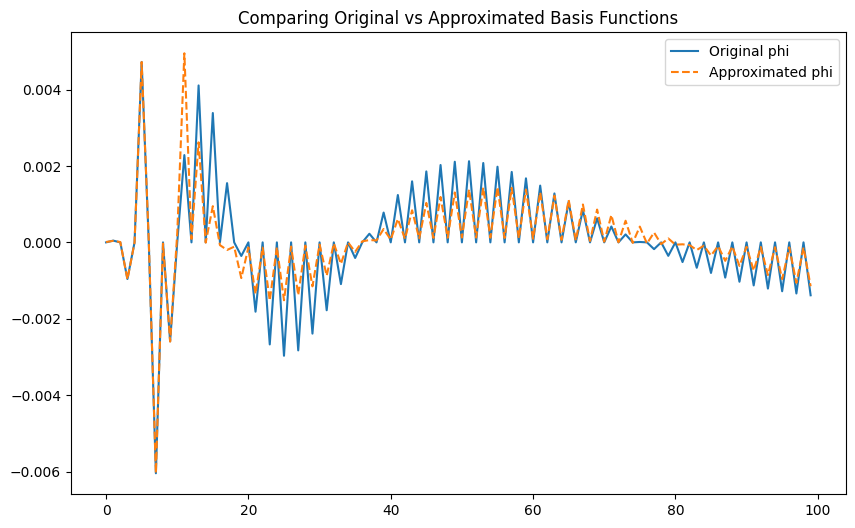

MSE between original and approximated phi: 2.42e-04


In [290]:
# Use pseudoinverse to solve for phi_n_combined
# reconstructed_filters = phi_n_combined @ combined_weights.T
# Therefore: phi_n_combined = reconstructed_filters @ pinv(combined_weights.T)
combined_weights_pinv = np.linalg.pinv(combined_weights.T)
combined_weights_pinv = torch.tensor(combined_weights_pinv, requires_grad=True).to(torch.float)
lds_impulses_tensor = torch.tensor(lds_impulses)
phi_n_combined_tensor = torch.tensor(phi_n_combined).to(torch.float)

# Gradient descent to refine the weights
optimizer = torch.optim.Adam([combined_weights_pinv], lr=1e-5)

for i in range(10000000):
    optimizer.zero_grad()
    
    # Forward pass
    phi_n_approx = torch.matmul(lds_impulses_tensor, combined_weights_pinv)
    
    # Calculate loss focusing on first column
    loss = F.mse_loss(phi_n_approx[:,0], phi_n_combined_tensor[:,0])
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item():.2e}")

# Convert back to numpy for plotting
phi_n_approx = torch.matmul(lds_impulses_tensor, combined_weights_pinv).detach()

# Compare original vs approximated phi_n
plt.figure(figsize=(10, 6))
plt.plot(phi_n_combined[:100,0], label='Original phi')
plt.plot(phi_n_approx[:100,0], '--', label='Approximated phi')
plt.title('Comparing Original vs Approximated Basis Functions')
plt.legend()
plt.show()

# Calculate MSE between original and approximated phi
mse = F.mse_loss(phi_n_combined_tensor, phi_n_approx)
print(f"MSE between original and approximated phi: {mse:.2e}")


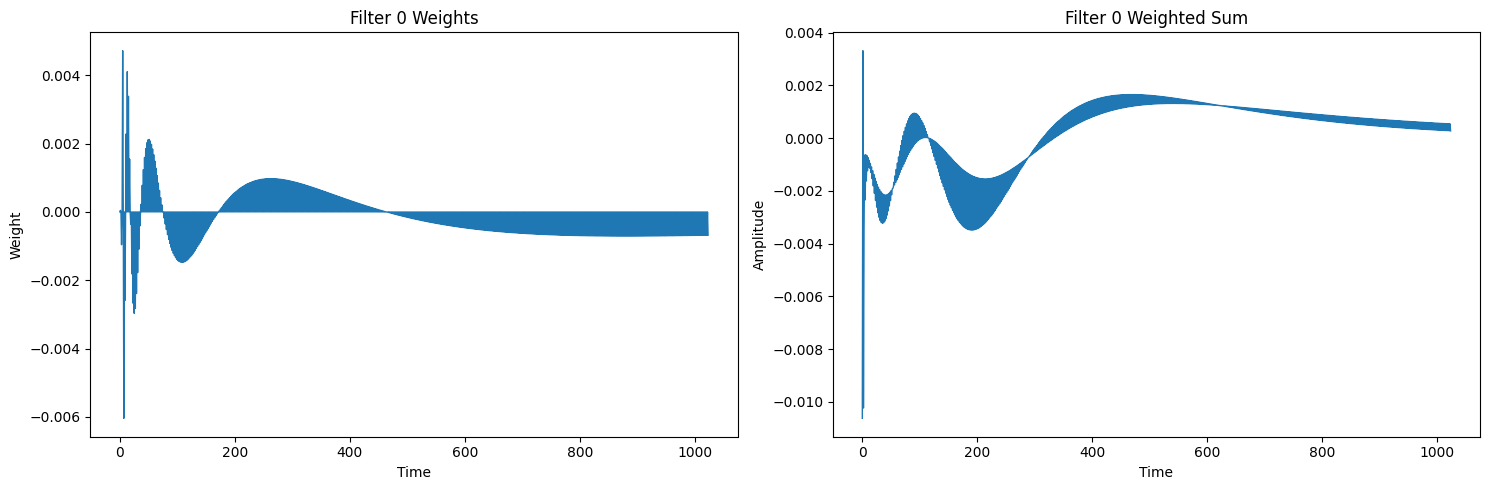

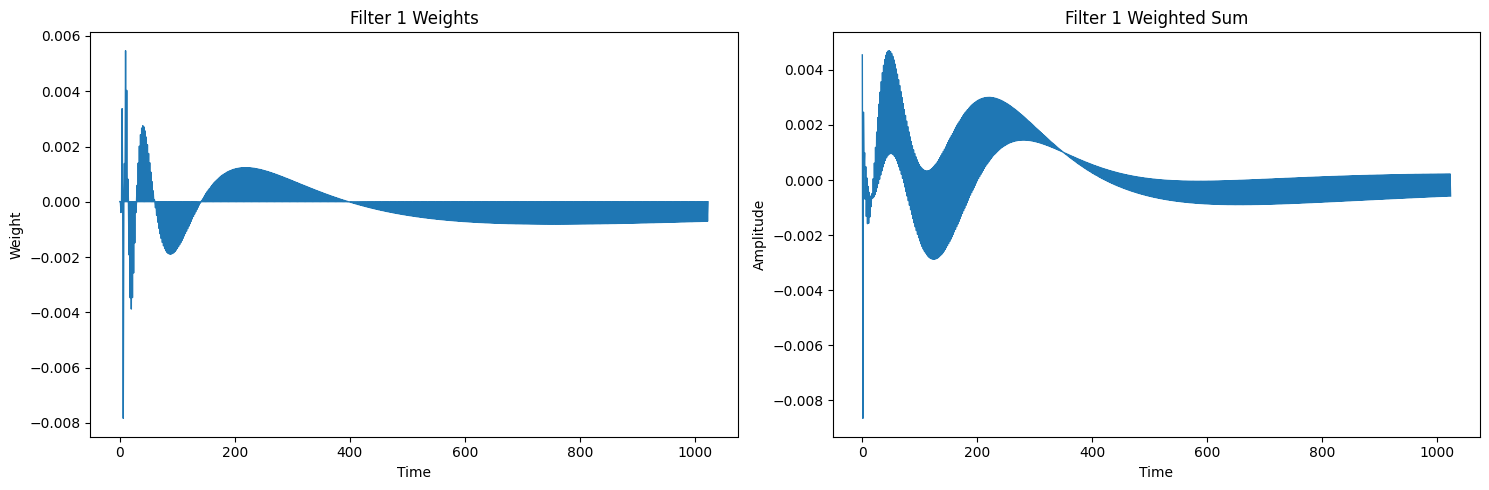

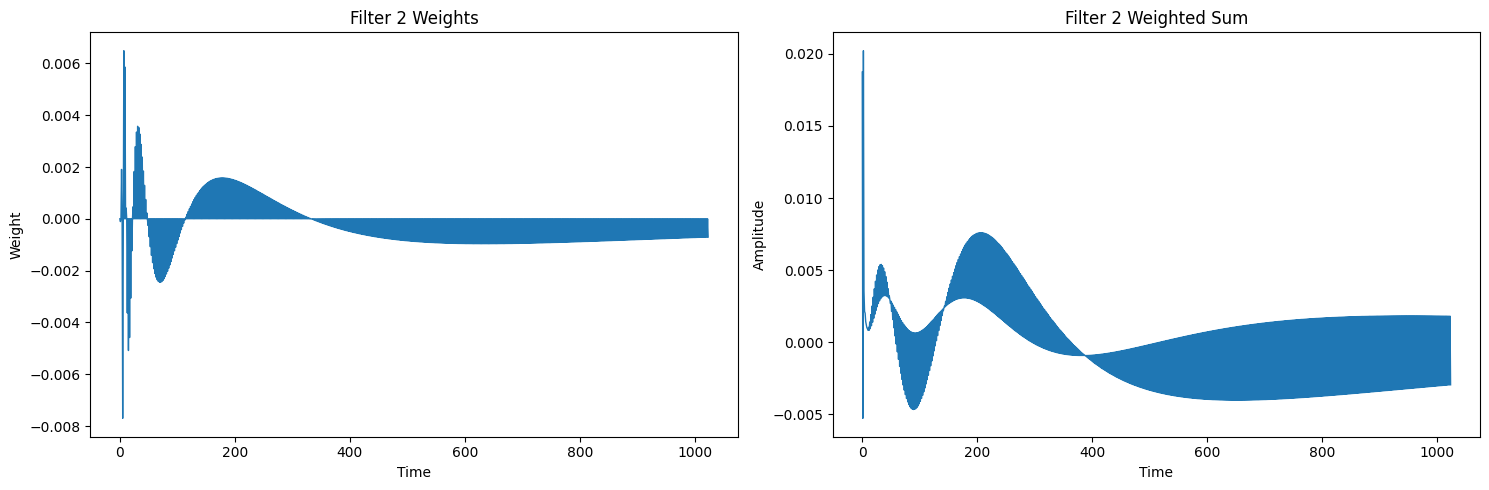

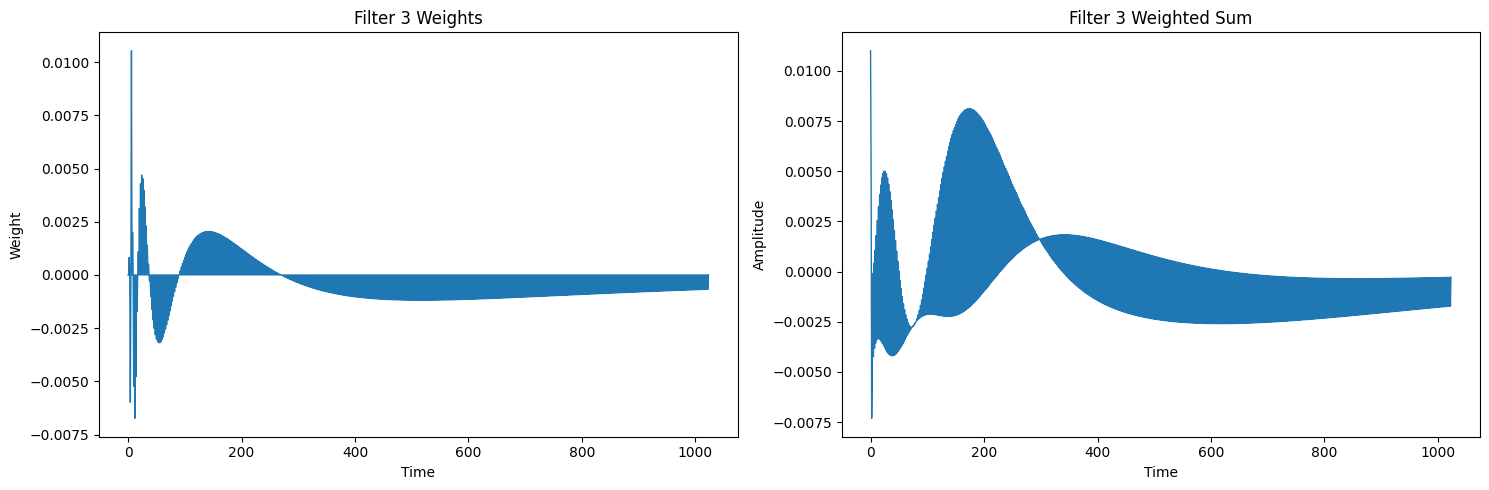

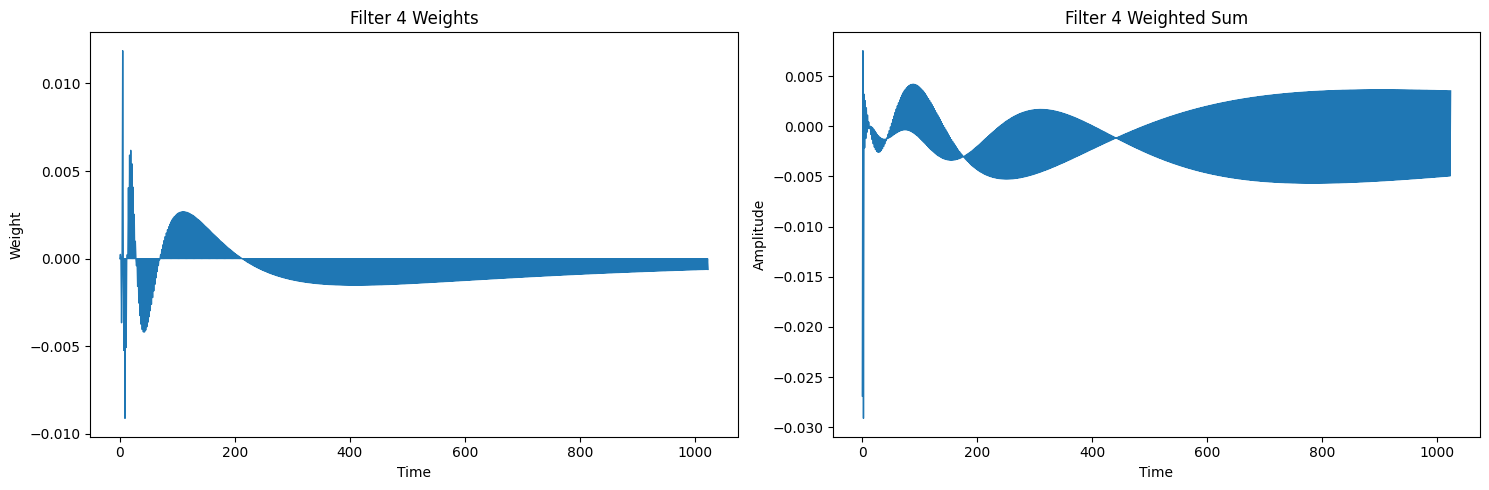

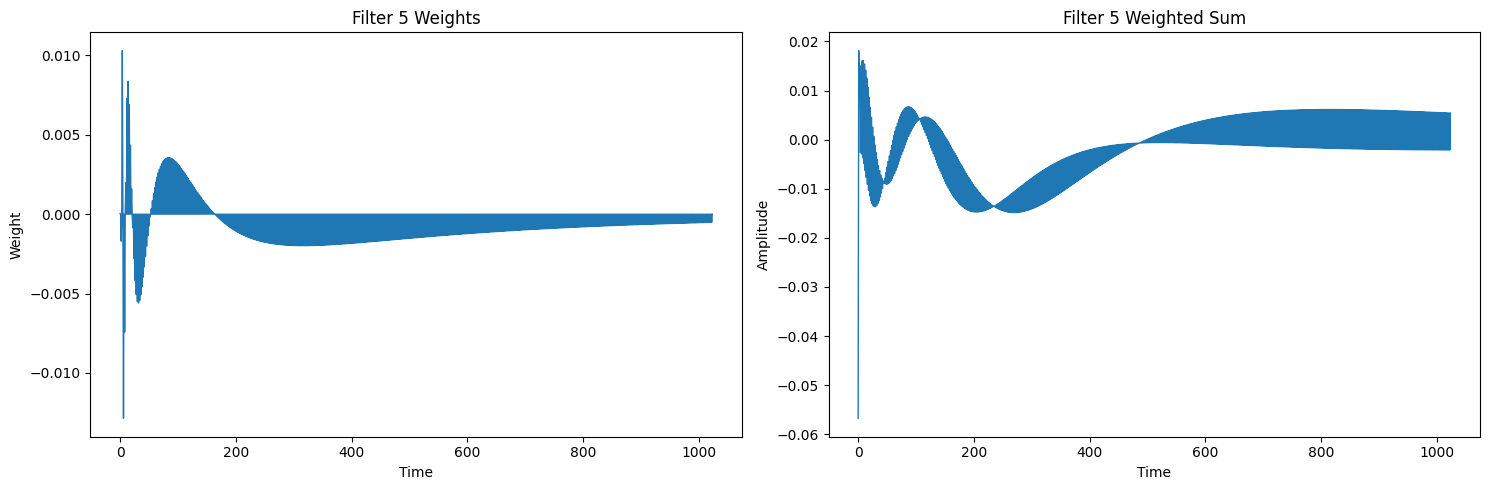

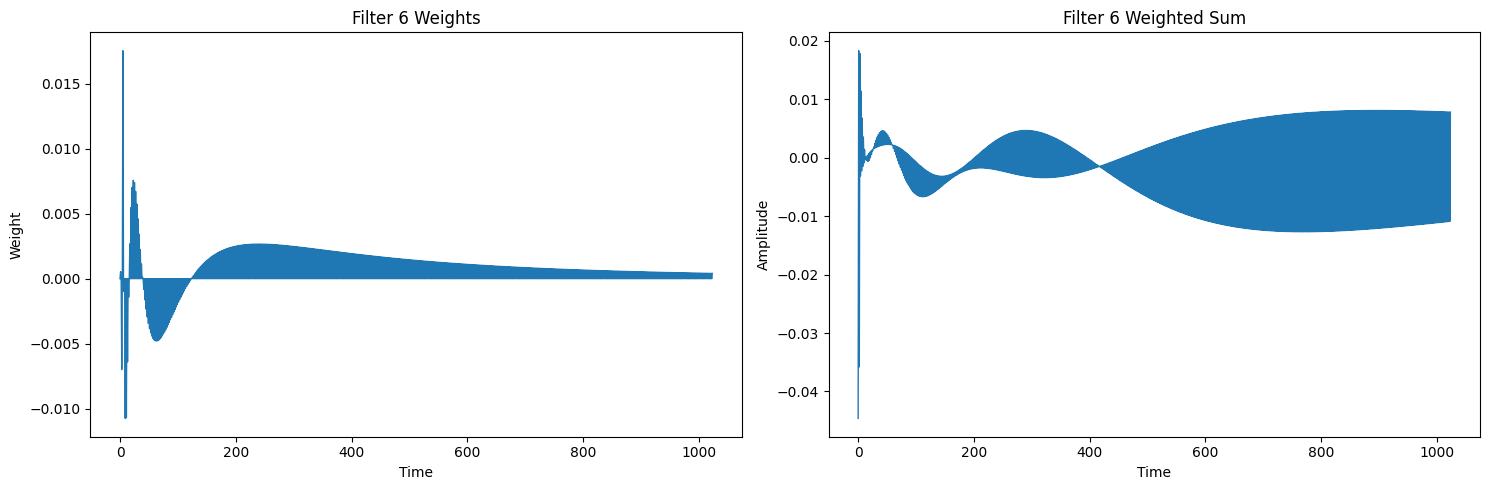

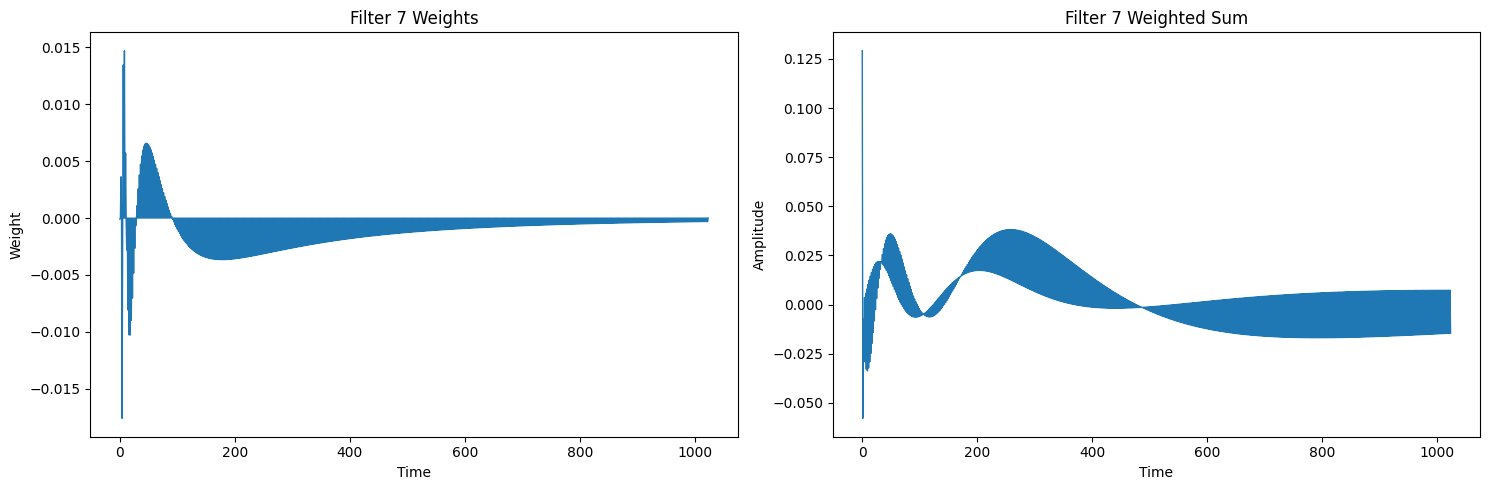

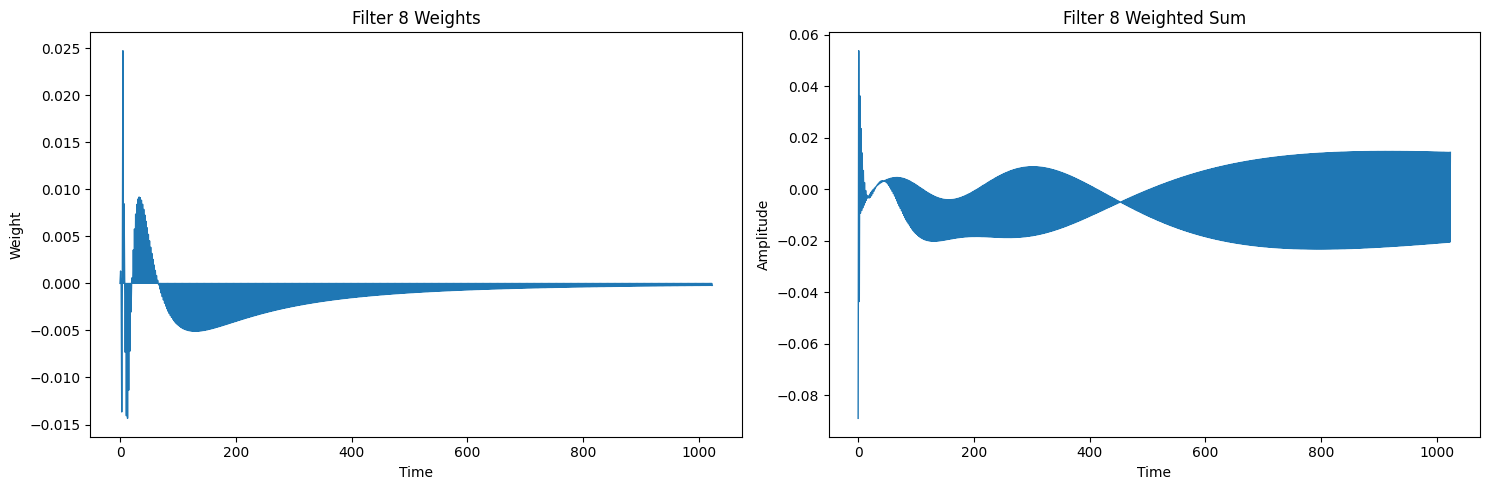

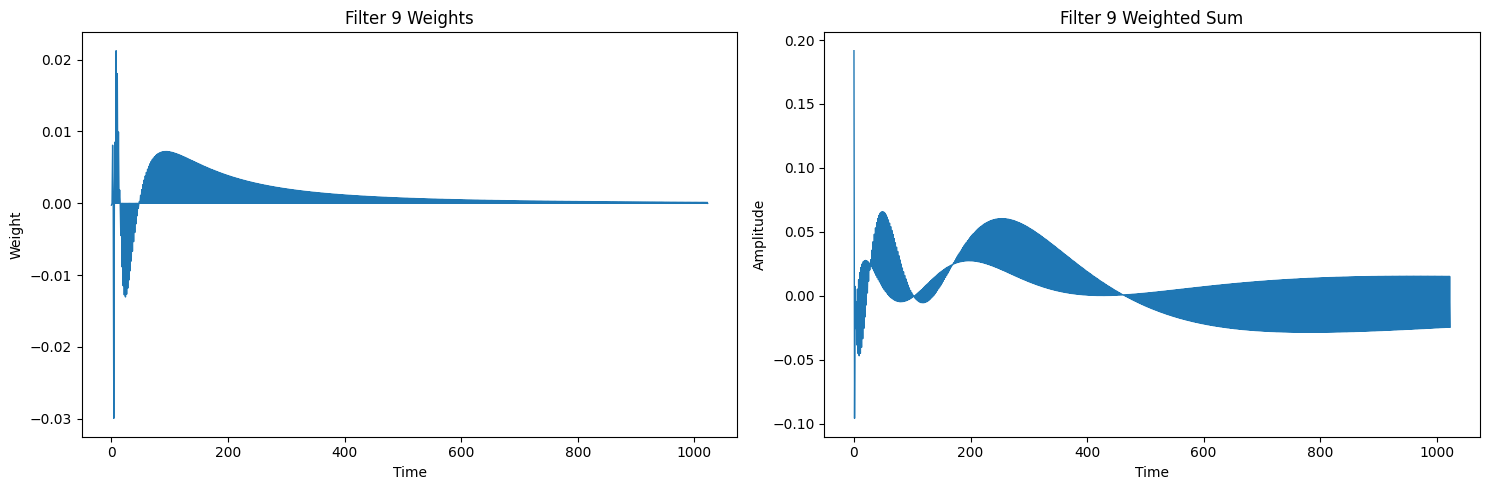

In [140]:
for i in range(10):
    plt.figure(figsize=(15, 5))
    
    # Plot the filter weights
    plt.subplot(1, 2, 1)
    plt.plot(phi[:,i].cpu(), '-', linewidth=1)
    plt.title(f'Filter {i} Weights')
    plt.xlabel('Time')
    plt.ylabel('Weight')
    
    # Plot the weighted sum of LDS impulses
    plt.subplot(1, 2, 2)
    coefficients = combined_weights_pinv[i]
    weighted_sum = torch.matmul(coefficients, lds_tensor)
    plt.plot(weighted_sum.detach().numpy(), '-', linewidth=1)
    plt.title(f'Filter {i} Weighted Sum')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()
